In [1]:
import numpy as np
import math
import cv2
import tifffile as tiff
from scipy import stats
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.ticker import AutoMinorLocator

In [2]:
input_path = "D:/Documents/_phd/main/programming/data/hsv_viewer_python/"
output_path = "D:/Documents/_phd/main/programming/computer_experiments/hsv_viewer_python/output/"

In [3]:
donor = tiff.imread(input_path+'AKAR3EV_Donor.tif')
acceptor = tiff.imread(input_path+'AKAR3EV_Acceptor.tif')
# Change it to float to make operations easy
donor_float = np.array(donor, dtype=np.float)
acceptor_float = np.array(acceptor, dtype=np.float)

In [4]:
print(donor.dtype == np.uint16)
print(donor_float.dtype == np.float)

True
True


max: 2555.0
min: 0.0
mean: 820.8073547363281
std: 742.6906519140636


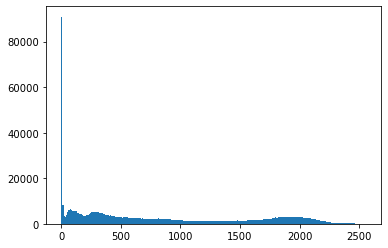

In [5]:
print('max:',np.max(donor_float))
print('min:',np.min(donor_float))
print('mean:',np.mean(donor_float))
print('std:',np.std(donor_float))
plt.hist(donor_float.ravel(), 256,[np.min(donor_float),np.max(donor_float)])
plt.show()

max: 3593.0
min: 0.0
mean: 1593.0726745605468
std: 1179.7164175009248


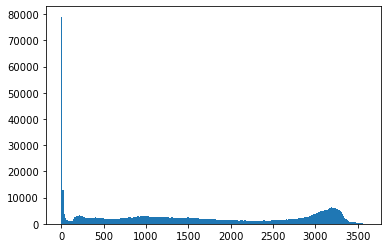

In [6]:
print('max:',np.max(acceptor_float))
print('min:',np.min(acceptor_float))
print('mean:',np.mean(acceptor_float))
print('std:',np.std(acceptor_float))
plt.hist(acceptor_float.ravel(), 256,[np.min(acceptor_float),np.max(acceptor_float)])
plt.show()

In [7]:
@interact(frame=(0, donor_float.shape[0]-1))
def display_image(frame):
    plt.subplot(121)
    plt.imshow(donor_float[frame],'gray')
    plt.subplot(122)
    plt.imshow(donor_float[frame],'gray')
    plt.show()

interactive(children=(IntSlider(value=4, description='frame', max=9), Output()), _dom_classes=('widget-interac…

In [143]:
D_frame = donor_float[8]
A_frame = acceptor_float[8]
# Divide the 2 images where donor is not zero and assigning zeros to those pixels insteaf of NaN
ratio = np.divide(A_frame, D_frame, out=np.zeros_like(A_frame), where=D_frame!=0)
print('Ratio min {};\nRatio max {};\nRatio mean {}'.format(ratio.min(), ratio.max(),ratio.mean()))
print(ratio.dtype)

Ratio min 0.0;
Ratio max 26.0;
Ratio mean 2.958605518177097
float64


In [10]:
def HSVtoRGB(hue, saturation, value):
    chroma = value * saturation
    Hp = hue / 60
    Xx = chroma * (1 - abs(Hp%2 - 1))
    m = value - chroma
    if 0 < Hp <= 1: r,g,b = chroma+m, Xx+m, m
    elif 1 < Hp <= 2: r,g,b = Xx, chroma+m, m
    elif 2 < Hp <= 3: r,g,b = m, chroma+m, Xx+m
    elif 3 < Hp <= 4: r,g,b = m, Xx+m, chroma+m
    elif 4 < Hp <= 5: r,g,b = Xx+m, m, chroma+m
    elif 5 < Hp <= 6: r,g,b = chroma+m, m, Xx+m
    else: r,g,b = (m,m,m)
        
    return r,g,b

In [11]:
def RGBForRatioIntensity(ratio, minRatio, maxRatio, intensity, minIntensity, maxIntensity):
    hue = (ratio - minRatio) / (maxRatio-minRatio) * 300
    hue = np.clip(hue, 0, 300)
    value = (intensity - minIntensity) / (maxIntensity - minIntensity)
    value = np.clip(value, 0, 1)
    saturation = 1
    
    return HSVtoRGB(hue, saturation, value)

In [12]:
def IMDImage(RatioImage, IntensityImage, minRatio, maxRatio, minIntensity, maxIntensity):
    M_IMD = np.empty((RatioImage.shape[0],RatioImage.shape[1],3), dtype=np.uint16)
    for row in range(RatioImage.shape[0]):
        for col in range(RatioImage.shape[1]):
            (red, green, blue) = RGBForRatioIntensity(RatioImage[row, col], minRatio, maxRatio, IntensityImage[row, col], minIntensity, maxIntensity)
            
            M_IMD[row,col,0] = red*65535
            M_IMD[row,col,1] = green*65535
            M_IMD[row,col,2] = blue*65535
    return M_IMD

In [13]:
from matplotlib import colors
def array2cmap(X):
    # Assuming array is Nx3, where x3 gives RGB values
    # Append 1's for the alpha channel, to make X Nx4
    X = np.c_[X,np.ones(len(X))]

    return colors.LinearSegmentedColormap.from_list('my_colormap', X)

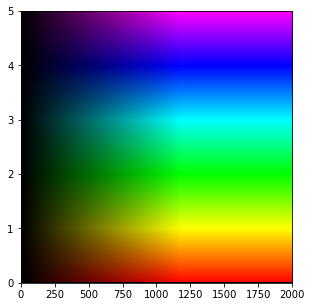

In [125]:
a = np.linspace(0,1, num=256)
b = np.linspace(0,255, num=256)
FakeRatio = np.tile(a, (256, 1)).T
FakeIntensity = np.tile(b, (256,1))
ColorBar = IMDImage(FakeRatio, FakeIntensity, 0, 1, 0 , 150)
ColorBar = np.flip(ColorBar,0)
f, ax = plt.subplots(figsize=(5,5))
ax.imshow(cv2.normalize(ColorBar, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX), cmap='rainbow_r', extent=[0,2000,0,5])
ax.set_aspect(400)
# ticks = ax.get_xticks()
# ax.set_xticklabels(ticks/10)
plt.show()

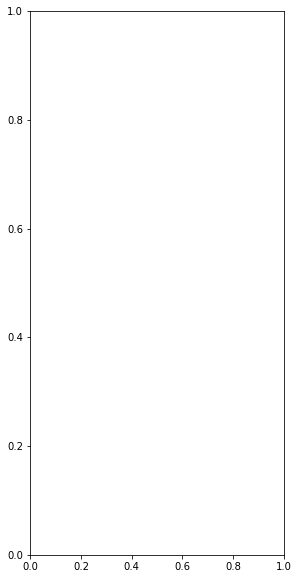

In [144]:
%matplotlib inline
def HSV_Display(minRatio, maxRatio, minInt, maxInt):
    IMAGE = IMDImage(ratio, D_frame, minRatio, maxRatio, minInt , maxInt)
    img_scaled = cv2.normalize(IMAGE, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    ax.imshow(img_scaled, vmin=0, vmax=img_scaled.max())
    fig.canvas.draw()
    display(fig)
    
fig = plt.figure(figsize=(10, 10), frameon=False)
ax = fig.add_subplot(121) 

In [145]:
interact(HSV_Display, minRatio=widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=0.0),
         maxRatio=widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=5.0),
         minInt=widgets.IntSlider(min=0, max=D_frame.max(), step=1, value=0),
         maxInt=widgets.IntSlider(min=0, max=D_frame.max(), step=1, value=5000))
plt.show()

interactive(children=(FloatSlider(value=0.0, description='minRatio', max=10.0), FloatSlider(value=5.0, descrip…

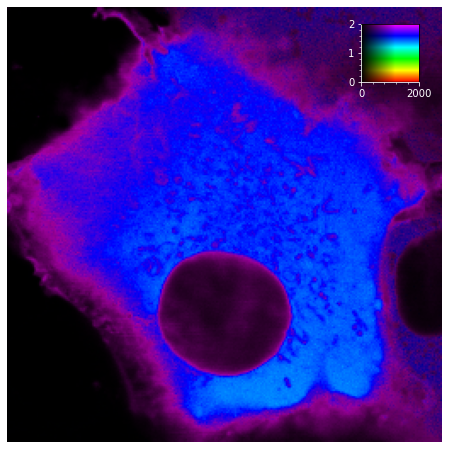

In [124]:
minRatio = 0
maxRatio = 2
minInt = 0
maxInt = 2000

IMAGE = IMDImage(ratio, D_frame, minRatio, maxRatio, minInt , maxInt)
img_scaled = cv2.normalize(IMAGE, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

fig, ax = plt.subplots(figsize=(8,8))

a = plt.axes([0.75,0.75,0.1,0.1])
a.imshow(cv2.normalize(ColorBar, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX), extent=[minInt, maxInt, minRatio, maxRatio])
scale_factor = (maxInt-minInt)/(maxRatio-minRatio)
a.set_aspect(scale_factor)
# a.invert_yaxis()
a.spines['bottom'].set_color('white')
a.spines['left'].set_color('white')
a.tick_params(axis='y', which='both', colors='white')
a.tick_params(axis='x', which='both', colors='white')
a.xaxis.set_minor_locator(AutoMinorLocator(5))
a.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.imshow(img_scaled)
ax.axis('off')
plt.show()